C:\Users\nkhalil\AppData\Local\Temp\ipykernel_6716\2675944386.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("data/img/dumbell.png")


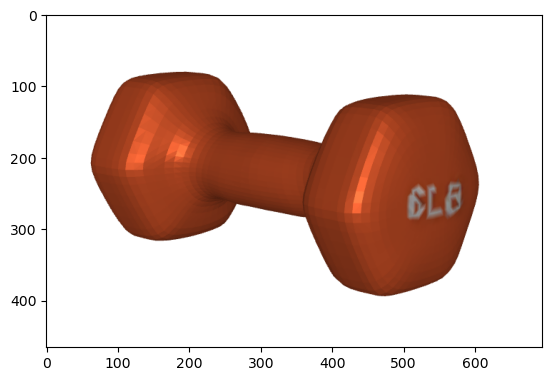

In [1]:
import matplotlib.pyplot as plt
import imageio
img = imageio.imread("data/img/dumbell.png")
plt.imshow(img)
plt.show()